### Проектная работа по модулю “Построение моделей”
#### В данной работе предлагается решить задачу бинарной классификации на большом признаковом множестве для датасета банка Santader (https://www.santanderbank.com/us/personal)
В этой работе я изменил порядок выполнения заданий, в пользу более логичного, на мой взгяд.

In [207]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision, recall_score as recall, f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit,KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import timeit
import copy

## Задание 1. Загрузить данные

In [2]:
data1 = pd.read_csv('train.csv')
# Гипотеза: Для того чтобы полученное модель не была переобучена необходимо удалить столбцы с прямой индексацией: ID 
data1.drop(['ID'], axis=1, inplace=True)

In [3]:
# Разделение на данных на целевые и фичи
ix=list(range(data1.shape[1]))
del ix[-1]
X=data1.values[:,ix]
y=data1.TARGET

## Задание 11. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
При помощи нижеописанной функции, начиная с этого момента, будет происходить оценка качества дерева решений. В качестве метрик оценки качества функция возвращает Accuracy, Precision, Recall, F1-Score.

In [164]:
# Функция оценки качества построения дерева решений.
def calc_rezult(X_trn,y_trn,X_tst,y_tst,n=1, var=1):
    if var>0:
        if var==1:# для анализа значимости фичей
            ix=list(range(X_trn.shape[1]))
            del ix[n]
        elif var==2:# для анализа количества фичей (минимально-оптимального)
            ix=list(range(n))
    elif var==0:# простой расчет качества дерева
        ix=list(range(X_trn.shape[1]))
    if str(type(X_trn))=="<class 'pandas.core.frame.DataFrame'>":
        X2_trn=X_trn.values[:,ix]
        X2_tst=X_tst.values[:,ix]
    else:
        X2_trn=X_trn[:,ix]
        X2_tst=X_tst[:,ix]
    model = DecisionTreeClassifier()
    model.fit(X2_trn, y_trn)
    y_pred = model.predict(X2_tst)
    return [accuracy(y_tst, y_pred), precision(y_tst, y_pred), recall(y_tst, y_pred), f1(y_tst, y_pred)]

## Задание 5. Шкалировать данные несколькими способами (нормализация, стандартизация). Какой подход лучше?

In [4]:
# Шкалирование различными методами
X_normTrans_l1 = copy.deepcopy(X)
X_normTrans_l2 = copy.deepcopy(X)
X_normScale    = copy.deepcopy(X)
X_normMiMa     = copy.deepcopy(X)
norm_trans_l1  = Normalizer(copy=True, norm='l1').fit(X_normTrans_l1)
norm_trans_l2  = Normalizer(copy=True, norm='l2').fit(X_normTrans_l2)
norm_scaler    = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_normScale)
mima_scaler    = MinMaxScaler(copy=True).fit(X_normMiMa)
X_normTrans_l1 = norm_trans_l1.transform(X_normTrans_l1)
X_normTrans_l2 = norm_trans_l2.transform(X_normTrans_l2)
X_normScale    = norm_scaler.transform(X_normScale)
X_normMiMa     = mima_scaler.transform(X_normMiMa)

In [6]:
# Для определения методики шкалирования произведем оценку следующих методик: Normalizer(l1 и l2), StandardScaler, MinMaxScaler
x_exp=np.arange(0,10,1);
y_exp_base=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_normTrans_l1=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_normTrans_l2=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_normScale=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_normMiMa=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
k=0
for i in tqdm(x_exp):
    # Разбиение на train и test выборки (с сохранением пропорционального соотношения 0 и 1 в целевых данных)
    sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
    sss.get_n_splits(X[y==0])
    trn_ix_0 , tst_ix_0 = next(sss.split(X[y==0]))
    sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
    sss.get_n_splits(X[y==1])
    trn_ix_1 , tst_ix_1 = next(sss.split(X[y==1]))
    trn_ix=np.concatenate([trn_ix_0,trn_ix_1], axis=0)
    tst_ix=np.concatenate([tst_ix_0,tst_ix_1], axis=0)
    # Расчет экспериментов
    y_exp_base[0][k], y_exp_base[1][k], y_exp_base[2][k], y_exp_base[3][k] = calc_rezult(X[trn_ix],y[trn_ix],X[tst_ix],y[tst_ix],n=0, var=0)
    y_exp_normTrans_l1[0][k], y_exp_normTrans_l1[1][k], y_exp_normTrans_l1[2][k], y_exp_normTrans_l1[3][k] = calc_rezult(X_normTrans_l1[trn_ix],y[trn_ix],X_normTrans_l1[tst_ix],y[tst_ix],n=0, var=0)
    y_exp_normTrans_l2[0][k], y_exp_normTrans_l2[1][k], y_exp_normTrans_l2[2][k], y_exp_normTrans_l2[3][k] = calc_rezult(X_normTrans_l2[trn_ix],y[trn_ix],X_normTrans_l2[tst_ix],y[tst_ix],n=0, var=0)
    y_exp_normScale[0][k], y_exp_normScale[1][k], y_exp_normScale[2][k], y_exp_normScale[3][k] = calc_rezult(X_normScale[trn_ix],y[trn_ix],X_normScale[tst_ix],y[tst_ix],n=0, var=0)
    y_exp_normMiMa[0][k], y_exp_normMiMa[1][k], y_exp_normMiMa[2][k], y_exp_normMiMa[3][k] = calc_rezult(X_normMiMa[trn_ix],y[trn_ix],X_normMiMa[tst_ix],y[tst_ix],n=0, var=0)
    k=k+1;   

100%|██████████| 10/10 [05:00<00:00, 29.88s/it]


In [7]:
# Таблица результатов анализа шкалирования
rez=np.array([y_exp_base.mean(axis=1),y_exp_normTrans_l1.mean(axis=1),y_exp_normTrans_l2.mean(axis=1),y_exp_normScale.mean(axis=1),y_exp_normMiMa.mean(axis=1),]).round(4)
print('\t\taccuracy\tprecision\trecall\t\tf1-score')
print('Base\t\t' + str(rez[0][0]) + '\t\t' + str(rez[0][1]) + '\t\t' + str(rez[0][2]) + '\t\t' + str(rez[0][3]))
print('Normalizer(l1)\t' + str(rez[1][0]) + '\t\t' + str(rez[1][1]) + '\t\t' + str(rez[1][2]) + '\t\t' + str(rez[1][3]))
print('Normalizer(l2)\t' + str(rez[2][0]) + '\t\t' + str(rez[2][1]) + '\t\t' + str(rez[2][2]) + '\t\t' + str(rez[2][3]))
print('StandardScaler\t' + str(rez[3][0]) + '\t\t' + str(rez[3][1]) + '\t\t' + str(rez[3][2]) + '\t\t' + str(rez[3][3]))
print('MinMaxScaler\t' + str(rez[4][0]) + '\t\t' + str(rez[4][1]) + '\t\t' + str(rez[4][2]) + '\t\t' + str(rez[4][3]))

		accuracy	precision	recall		f1-score
Base		0.9341		0.1804		0.1905		0.1852
Normalizer(l1)	0.9341		0.1718		0.177		0.1743
Normalizer(l2)	0.9333		0.1703		0.1804		0.1751
StandardScaler	0.9339		0.1796		0.1908		0.1849
MinMaxScaler	0.9337		0.1741		0.1835		0.1785


По результатам анализа метода шкалирования видно, что лучше оставить данные в исходном виде (скорее всего они уже были шкалированы ранее)

## Задание 6. Попробовать стратегию oversamling и сравнить ее с неизмененной моделью
## Задание 7. Попробовать стратегию undersampling и сравнить ее с неизмененной моделью

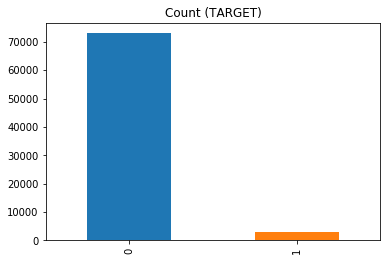

In [8]:
# Как можно видеть исходная выборка TARGET не сбалансирована.
y.value_counts().plot(kind='bar', title='Count (TARGET)');
# Потому произведем анализ 2-х подходов oversampling и undersampling

In [102]:
# Функция oversampling/undersampling аназиза
def sampling_analyze(data1,var=1,k=1):
    count_class_0, count_class_1 = data1.TARGET.value_counts()
    df_class_0 = data1[data1['TARGET']==0]
    df_class_1 = data1[data1['TARGET']==1]
    if var==1:#undersampling
        df_class_0 = df_class_0.sample(count_class_1)
    elif var==2:#oversampling
        df_class_1 = df_class_1.sample(count_class_0, replace=True)
    df_class_0.reset_index();
    df_class_1.reset_index();
    sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
    sss.get_n_splits(df_class_0)
    if var<3:
        trn_ix , tst_ix = next(sss.split(df_class_0))
        df_tst = pd.concat([pd.DataFrame(df_class_0.values[tst_ix], columns=df_class_0.columns),pd.DataFrame(df_class_1.values[tst_ix], columns=df_class_1.columns)], axis=0)
        df_trn = pd.concat([pd.DataFrame(df_class_0.values[trn_ix], columns=df_class_0.columns),pd.DataFrame(df_class_1.values[trn_ix], columns=df_class_1.columns)], axis=0)
    else:
        trn_ix_0 , tst_ix_0 = next(sss.split(df_class_0))
        trn_ix_1 , tst_ix_1 = next(sss.split(df_class_1))
        df_tst = pd.concat([pd.DataFrame(df_class_0.values[tst_ix_0], columns=df_class_0.columns),pd.DataFrame(df_class_1.values[tst_ix_1], columns=df_class_1.columns)], axis=0)
        df_trn = pd.concat([pd.DataFrame(df_class_0.values[trn_ix_0], columns=df_class_0.columns),pd.DataFrame(df_class_1.values[trn_ix_1], columns=df_class_1.columns)], axis=0)
    y_trn=pd.DataFrame(df_trn.TARGET,columns=['TARGET'])
    X_trn=df_trn
    X_trn.drop(['TARGET'], axis=1, inplace=True)
    y_tst=pd.DataFrame(df_tst.TARGET,columns=['TARGET'])
    X_tst=df_tst
    X_tst.drop(['TARGET'], axis=1, inplace=True)
    return [calc_rezult(X_trn,y_trn,X_tst,y_tst,0, 0), [X_trn,X_tst,y_trn,y_tst]]

In [107]:
x_exp=np.arange(0,10,1);
y_exp_base=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_under=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_over=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_time=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
k=0;
time1 = timeit.default_timer();time2 = timeit.default_timer();time3 = timeit.default_timer();time4 = timeit.default_timer();
for i in tqdm(x_exp):
    time1 = timeit.default_timer()
    y_exp_base[0][k], y_exp_base[1][k], y_exp_base[2][k], y_exp_base[3][k] = sampling_analyze(data1,3,k)[0]
    time2 = timeit.default_timer()
    y_exp_under[0][k], y_exp_under[1][k], y_exp_under[2][k], y_exp_under[3][k] = sampling_analyze(data1,1,k)[0]
    time3 = timeit.default_timer()
    y_exp_over[0][k], y_exp_over[1][k], y_exp_over[2][k], y_exp_over[3][k]  = sampling_analyze(data1,2,k)[0]
    time4 = timeit.default_timer()
    y_exp_time[0][k] = time2-time1
    y_exp_time[1][k] = time3-time2
    y_exp_time[1][k] = time4-time3
    k=k+1;   

100%|██████████| 10/10 [02:11<00:00, 13.12s/it]


In [111]:
bas=np.concatenate((y_exp_base.mean(axis = 1),[y_exp_time[0].mean()]), axis=0)
bas=bas.round(3)
rUn=np.concatenate((y_exp_under.mean(axis = 1),[y_exp_time[1].mean()]), axis=0)
rUn=rUn.round(3)
rOv=np.concatenate((y_exp_over.mean(axis = 1),[y_exp_time[2].mean()]), axis=0)
rOv=rOv.round(3)
delta=rOv-rUn
delta=(100*(delta/rUn)).round(0)
print('\t\taccuracy\tprecision\trecall\t\tf1-score\ttime')
print('base\t\t' + str(bas[0]) + '\t\t' + str(bas[1]) + '\t\t' + str(bas[2]) + '\t\t' + str(bas[3]) + '\t\t' + str(bas[4]))
print('undersampling\t' + str(rUn[0]) + '\t\t' + str(rUn[1]) + '\t\t' + str(rUn[2]) + '\t\t' + str(rUn[3]) + '\t\t' + str(rUn[4]))
print('oversampling\t' + str(rOv[0]) + '\t\t' + str(rOv[1]) + '\t\t' + str(rOv[2]) + '\t\t' + str(rOv[3]) + '\t\t' + str(rOv[4]))
print('delta(und-over)\t' + str(delta[0]) + '%\t\t' + str(delta[1]) + '%\t\t' + str(delta[2]) + '%\t\t' + str(delta[3]) + '%' + '%\t\t' + str(delta[4]) + '%')

		accuracy	precision	recall		f1-score	time
base		0.929		0.129		0.138		0.133		4.875
undersampling	0.681		0.682		0.677		0.68		0.355
oversampling	0.967		0.944		0.992		0.967		7.882
delta(und-over)	42.0%		38.0%		47.0%		42.0%%		2120.0%


Как можно видеть, несмотря на то, что undersempling значительно быстрее (за счет меньшей выборки), oversempling - много точнее.
Поэтому здесь и далее, будет использован oversempling.
Что касается исходной (базовой) выборки, она находится примерно по середине между undersempling  и oversempling по времени счета, и все еще имеет неудовлетворительное качество.

In [12]:
X_trn , X_tst , y_trn , y_tst = sampling_analyze(data1,2,5)[1]
X=np.concatenate([X_trn,X_tst])
y=np.concatenate([y_trn,y_tst])
print([X.shape,y.shape])

[(146024, 369), (146024, 1)]


## Задание 4. Провести стратегию Feature Selection (попробовать как минимум два различных подхода)
## Задание 10. Рассчитать Feature Importances для переменных модели

##### Так как исходные данные содержат 370 столбцов входных данных первая задача это сократить это число как минимум вдвое.
##### Для этого применим два подхода:
#####    - анализ значимости компонент
#####    - метод главных компанент (далее МГК)

In [16]:
# Анализ значимости компонент
x_exp=np.arange(0,X_trn.shape[1],1);
y_exp=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
k=0;
for i in tqdm(x_exp):
    y_exp[0][k], y_exp[1][k], y_exp[2][k], y_exp[3][k] =calc_rezult(X_trn,y_trn,X_tst,y_tst,i,1)
    k=k+1;

100%|██████████| 369/369 [36:00<00:00,  5.69s/it]


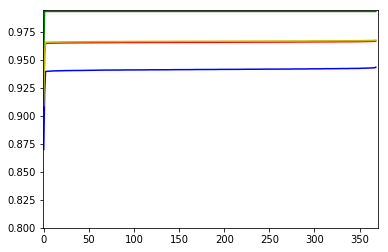

In [17]:
ix=np.argsort(y_exp[3])
plt.plot(x_exp,y_exp[0][ix],'r-')
plt.plot(x_exp,y_exp[1][ix],'b-')
plt.plot(x_exp,y_exp[2][ix],'g-')
plt.plot(x_exp,y_exp[3][ix],'y-')
plt.xlim(-1, 370);plt.ylim(0.8, 0.994)
plt.show()

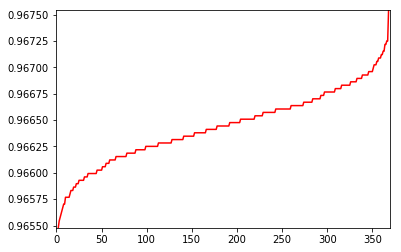

In [41]:
plt.plot(np.sort(y_exp[3]),'r')
plt.xlim(-1, 370); plt.ylim(np.sort(y_exp[3])[2], np.sort(y_exp[3])[-1]);
# Произведем ранжирование по параметру f1-score

In [19]:
ix0=np.argsort(y_exp[3])
X2_trn=pd.DataFrame(X_trn.values[:,x_exp[ix0]], columns=X_trn.columns[x_exp[ix0]])
X2_tst=pd.DataFrame(X_tst.values[:,x_exp[ix0]], columns=X_tst.columns[x_exp[ix0]])
X2=np.concatenate([X2_trn,X2_tst])
ix_train=np.ones(X2.shape[0])
ix_train[X2_trn.shape[0]:]=0

Теперь произведем сравнение полученного ранжированного массива с МГК. Причем попутно оценим оптимальное количество компонент.
Для этого будем брать по одной компоненте начиная с первой и добавлять на каждом шаге еще одну (следующую по значимости).
Одновременно с этим используем МГК при выделении k-компонент, причем брать k = количству компонент в методе ранжирования.

In [59]:
# Так как подобный расчет занимает достаточно большое время,
#  а общая тенденция проясница уже на первых итерациях,
#   то не имеет смысла делать его для трети всего набока признаков,
#    ограничемся третью от общего числа.
x_exp=np.arange(1,int(X_trn.shape[1]/3),1);
#x_exp=np.arange(1,10,1);
y_exp_range=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_pca=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
y_exp_time=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
time1 = timeit.default_timer();time2 = timeit.default_timer();time3 = timeit.default_timer()
k=0;
for i in tqdm(x_exp):
    time1 = timeit.default_timer()
    y_exp_range[0][k], y_exp_range[1][k], y_exp_range[2][k], y_exp_range[3][k] = calc_rezult(X2_trn,y_trn,X2_tst,y_tst,int(x_exp[k]),2)
    time2 = timeit.default_timer()
    pca=PCA(n_components=int(i))
    X_pca = pca.fit_transform(X2)
    X_pca_trn=X_pca[ix_train==1]
    X_pca_tst=X_pca[ix_train==0] 
    y_exp_pca[0][k], y_exp_pca[1][k], y_exp_pca[2][k], y_exp_pca[3][k] = calc_rezult(X_pca_trn,y_trn,X_pca_tst,y_tst,0,0)
    time3 = timeit.default_timer()
    y_exp_time[0][k] = time2-time1
    y_exp_time[1][k] = time3-time2
    k=k+1; 

100%|██████████| 122/122 [30:59<00:00, 30.16s/it]


f1-score


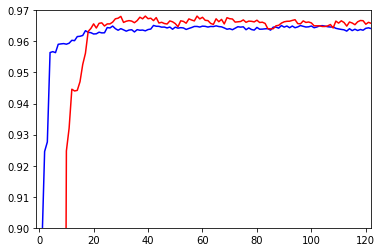

time


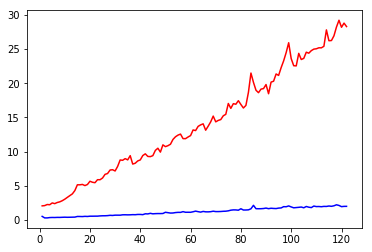

f1-score (ZOOM)


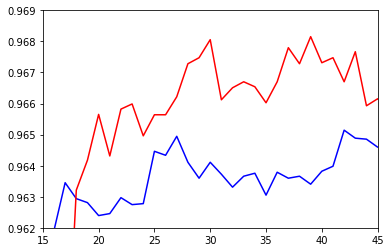

time (ZOOM)


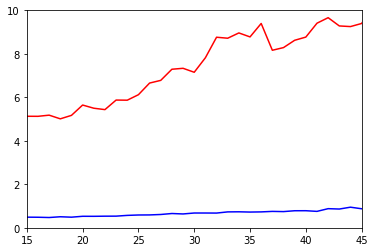

In [92]:
print('f1-score')
plt.plot(x_exp,y_exp_range[3],'b')
plt.plot(x_exp,y_exp_pca[3],'r')
plt.xlim(-1, y_exp_range.shape[1]); plt.ylim(0.9, 0.97);
plt.show()
print('time');
plt.plot(x_exp,y_exp_time[0],'b')
plt.plot(x_exp,y_exp_time[1],'r')
plt.show()
print('f1-score (ZOOM)')
plt.plot(x_exp,y_exp_range[3],'b')
plt.plot(x_exp,y_exp_pca[3],'r')
plt.xlim(15, 45); plt.ylim(0.962, 0.969);
plt.show()
print('time (ZOOM)'); 
plt.plot(x_exp,y_exp_time[0],'b')
plt.plot(x_exp,y_exp_time[1],'r')
plt.xlim(15, 45);plt.ylim(0, 10);
plt.show()

Как видно из графиков начиная с 18 компанентов МГК обгоняет ранжирование. Так же видно, что есть два пика значений f1-score: при 30 и при 39 и их значения похожи, однако из графика времени расчета следует что МГК(30) быстрее чем МГК(39).
Таким образом здесь и далее для расчета будет использован МГК(30).

In [206]:
pca=PCA(n_components=30)
X_pca = pca.fit_transform(X2)
X_pca_trn=X_pca[ix_train==1]
X_pca_tst=X_pca[ix_train==0]

## Задание 2. Провести описательный анализ предложенных данных
Поскольку изночальный массив данных был слишком велик и содержал явно избыточное количество признаков было не целесообразно производить их описательный анализ.
Теперь, после ранжирования признаков и выявления самых значимых из них проведем такой анализ для первых 17 признаков (т.к. по результатам сравнения с МГК это последнее значение с большим f1-score)

In [218]:
X2_df=pd.DataFrame(X2[:,range(17)],columns=data1.columns[ix0[range(17)]])
X2_df.describe()

,var38,var15,num_var13_corto,saldo_medio_var5_ult3,ind_var13_medio_0,num_trasp_var33_in_hace3,num_meses_var39_vig_ult3,imp_amort_var18_hace3,delta_num_aport_var17_1y3,num_op_var40_hace3,ind_var46_0,num_var26_0,num_var5_0,num_var12_0,imp_op_var41_efect_ult3,imp_trasp_var33_in_hace3,num_med_var22_ult3
count,1.460240e+05,146024.000000,146024.000000,146024.000000,146024.000000,146024.000000,146024.000000,146024.0,1.460240e+05,146024.000000,146024.0,146024.000000,146024.000000,146024.000000,146024.000000,146024.000000,146024.000000
mean,1.089267e+05,36.302519,0.075809,672.203441,0.000014,0.000123,1.573015,0.0,4.519805e+06,0.000534,0.0,0.114947,2.851833,0.153940,160.006258,1.452354,0.704966
std,1.507982e+05,12.921317,0.471094,6232.701338,0.003701,0.019230,0.757277,0.0,2.125510e+08,0.130425,0.0,0.714487,0.746845,1.452801,941.669665,233.643735,2.116828
min,5.163750e+03,5.000000,0.000000,-476.070000,0.000000,0.000000,0.000000,0.0,-1.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.232464e+04,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000e+00,0.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,9.645724e+04,33.000000,0.000000,2.070000,0.000000,0.000000,2.000000,0.0,0.000000e+00,0.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,1.173110e+05,44.000000,0.000000,44.580000,0.000000,0.000000,2.000000,0.0,0.000000e+00,0.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,2.203474e+07,105.000000,6.000000,544365.570000,1.000000,3.000000,3.000000,0.0,1.000000e+10,48.000000,0.0,33.000000,15.000000,111.000000,131100.000000,49581.270000,78.000000


## Задание 3. Провести анализ корреляции переменных, отобразить взаимосвязи между переменными
А теперь, посмотрим на кросс-корреляцию этих 17-и признаков.

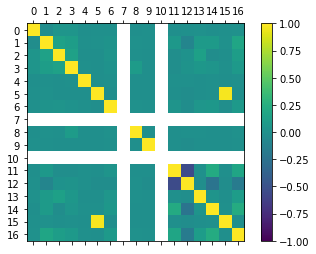

In [219]:
# Correction Matrix Plot
names = X2_df.columns
#data = pandas.read_csv(url, names=names)
correlations = X2_df.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,X2_df.shape[1])
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

## Задание 8. Сделать кросс-валидацию тренировочных данных с использованием подхода K-fold (n_folds=10)

In [125]:
# Так как количиство фичей большое (106) проведем простой анализ МГК
n_kfold=10
kf = KFold(n_splits=n_kfold, random_state=5, shuffle=True)
x_exp=np.arange(n_kfold)
y_exp=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
stop = timeit.default_timer()
k=0;
for trn_ix, tst_ix in tqdm(kf.split(X_pca,y)):
    y_exp[0][k], y_exp[1][k], y_exp[2][k], y_exp[3][k] = calc_rezult(X_pca[trn_ix],y[trn_ix],X_pca[tst_ix],y[tst_ix], 0, 0)
    k=k+1

10it [00:35,  3.52s/it]


Accuracy


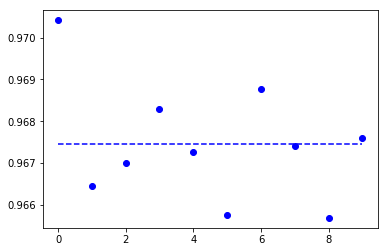

Precision


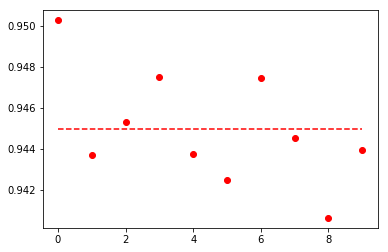

Recall


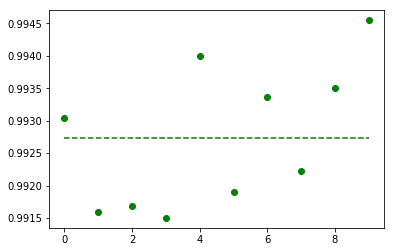

Score


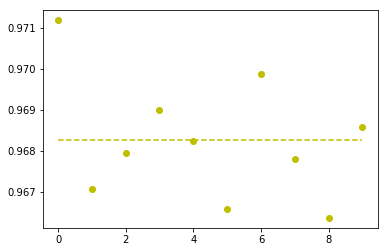

In [137]:
plt.plot(x_exp,y_exp[0],'bo')
plt.plot([x_exp[0],x_exp[-1]],[y_exp[0].mean(),y_exp[0].mean()],'b--')
print('Accuracy')
plt.show()
plt.plot(x_exp,y_exp[1],'ro')
plt.plot([x_exp[0],x_exp[-1]],[y_exp[1].mean(),y_exp[1].mean()],'r--')
print('Precision')
plt.show()
plt.plot(x_exp,y_exp[2],'go')
plt.plot([x_exp[0],x_exp[-1]],[y_exp[2].mean(),y_exp[2].mean()],'g--')
print('Recall')
plt.show()
plt.plot(x_exp,y_exp[3],'yo')
plt.plot([x_exp[0],x_exp[-1]],[y_exp[3].mean(),y_exp[3].mean()],'y--')
print('Score')
plt.show()

## Задание 9. Решить задачу бинарной классификации и предсказать удовлетворение клиентов банка (переменная TARGET)

In [175]:
# Разбиение на train и test выборки (с сохранением пропорционального соотношения 0 и 1 в целевых данных)
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
sss.get_n_splits(X_pca[ix_train==0])
trn_ix_0 , tst_ix_0 = next(sss.split(X_pca[ix_train==0]))
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
sss.get_n_splits(X_pca[ix_train==1])
trn_ix_1 , tst_ix_1 = next(sss.split(X_pca[ix_train==1]))
trn_ix=np.concatenate([trn_ix_0,trn_ix_1], axis=0)
tst_ix=np.concatenate([tst_ix_0,tst_ix_1], axis=0)
# Расчет
model = DecisionTreeClassifier()
model.fit(X_pca[trn_ix], y[trn_ix])
y_pred = model.predict(X_pca)
# Результаты
print('accuracy:\t' + str(accuracy(y[tst_ix], y_pred[tst_ix]).round(4)))
print('precision:\t' + str(precision(y[tst_ix], y_pred[tst_ix]).round(4)))
print('recall:\t\t' + str(recall(y[tst_ix], y_pred[tst_ix]).round(4)))
print('f1-score:\t' + str(f1(y[tst_ix], y_pred[tst_ix]).round(4)))

accuracy:	0.9713
precision:	0.9412
recall:		0.9901
f1-score:	0.965


## Задание 12. Построить Confusion Matrix для ваших результатов

In [194]:
cm=(100*confusion_matrix(y[tst_ix], y_pred[tst_ix])/tst_ix.shape[0]).round(1)

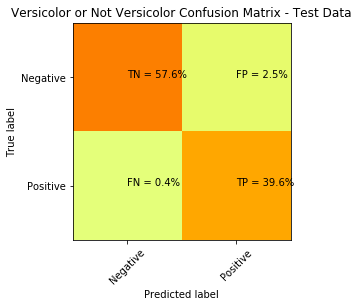

In [196]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j])+'%')
plt.show()